
<div style='text-align: center'>
    <h4>University of Berkeley: Machine Learning and AI Capstone Project (July 2025)</h4>
    <h2>Diabetic Readmission Prediction Using Machine Learning Models</h2>
</div>


#### Load all the required Libraries for the Capstone Project

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, roc_curve, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import joblib
import time
import datetime

import warnings
warnings.filterwarnings('ignore')


#### Load Data Set 

In [2]:
# Load dataset
df = pd.read_csv('diabetic_data.csv')

print("Before droppoing NaNs:", df.shape)

Before droppoing NaNs: (101766, 50)


#### Dataset Overview
- **Rows**: 101,766  
- **Columns**: 50  
- **Target Variable**: `readmitted` (`NO`, `>30`, `<30`)
####  Data Types
- **Numeric Columns**: 13  
  _(e.g., `time_in_hospital`, `num_lab_procedures`, `number_inpatient`)_
- **Categorical Columns**: 37  
  _(e.g., `race`, `gender`, `medical_specialty`, `insulin`, etc.)_
#### Key Observations
##### 🔹 Missing / Placeholder Values
    - `weight`: Most values are `'?'` (≈98.5% missing)
    - `payer_code`, `medical_specialty`: High frequency of `'?'`, but not entirely missing
- **Note**: Missing values are coded as `'?'` (not `NaN`) → **must be cleaned before modeling**
##### 🔹 Demographics
    - `race`: Over **76,000** records labeled as **Caucasian**
    - `gender`: More **females** than **males**
    - `age`: Categorized in 10-year brackets like `[50-60)`, `[70-80)`, etc.
##### 🔹 Hospitalization
    - `time_in_hospital`: Ranges from **1 to 14 days**
    - Utilization tracked via features like `number_emergency`, `number_inpatient`, etc.
##### 🔹 Medication Use
    - Multiple columns track diabetes medication usage  
      _(e.g., `insulin`, `metformin`, `glyburide`, etc.)_
    - Values: **No**, **Steady**, **Up**, **Down**
#### Target Variable: `readmitted`
- `NO`: 54,864 records (~54%) – **not readmitted**
- `>30`: Readmitted **after** 30 days
- `<30`: Readmitted **within 30 days** → **most critical for modeling**


#### Exploratory Data Analysis

In [6]:

df = df.dropna()
print("After dropping NaNs:", df.shape)

df.replace('?', np.nan, inplace=True)
df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)
df.dropna(inplace=True)
df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

# Encode categorical columns
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

print("Cleaned data shape:", df.shape)


After dropping NaNs: (298, 50)
Cleaned data shape: (289, 45)


#### Categorical Variables Visualization

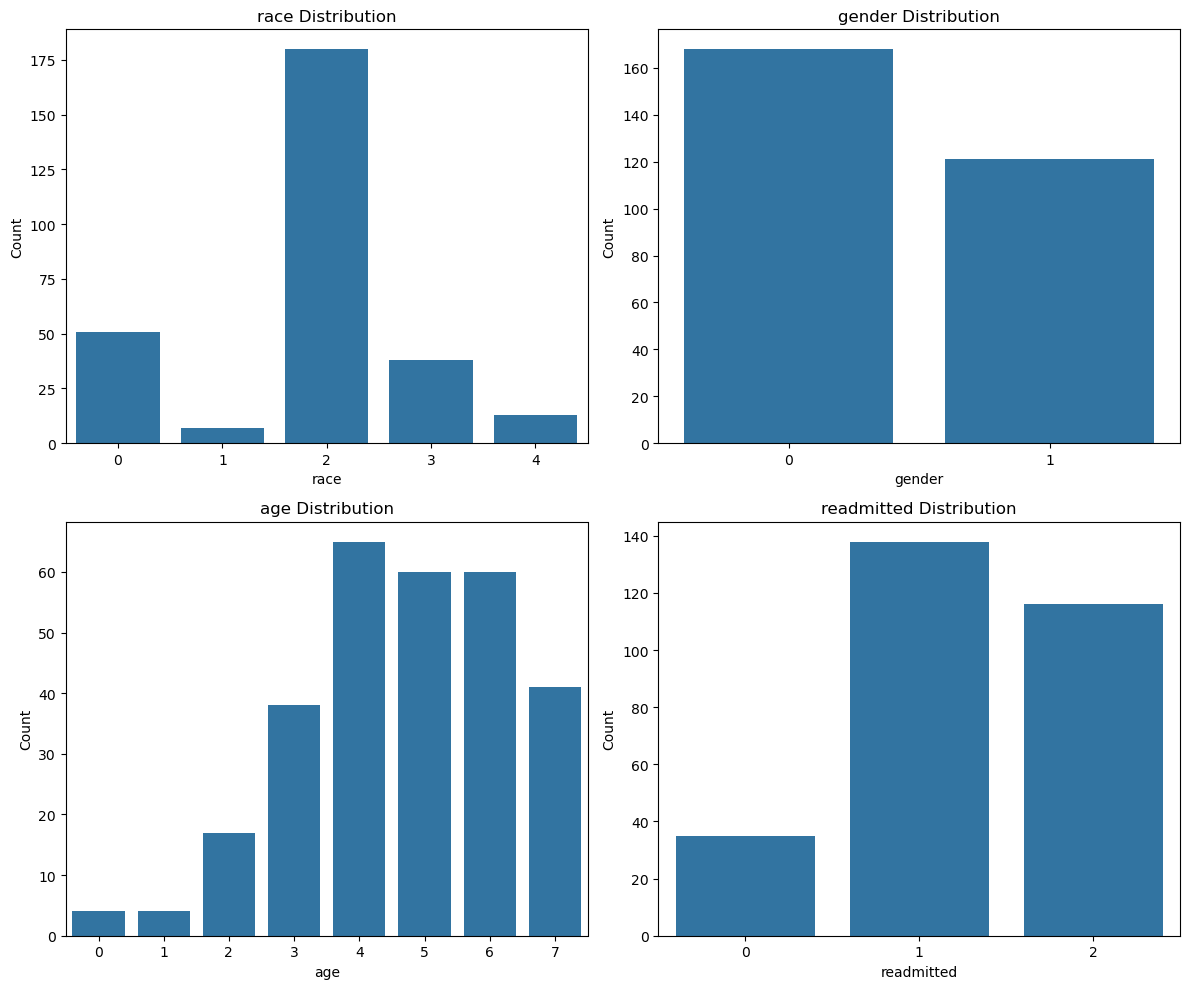

In [8]:
categorical_cols = ['race', 'gender', 'age', 'readmitted']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, col in enumerate(categorical_cols):
    ax = axes[i//2, i%2]
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_title(f'{col} Distribution')
    ax.set_ylabel('Count')
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()


#### Continuous Variable Visualization

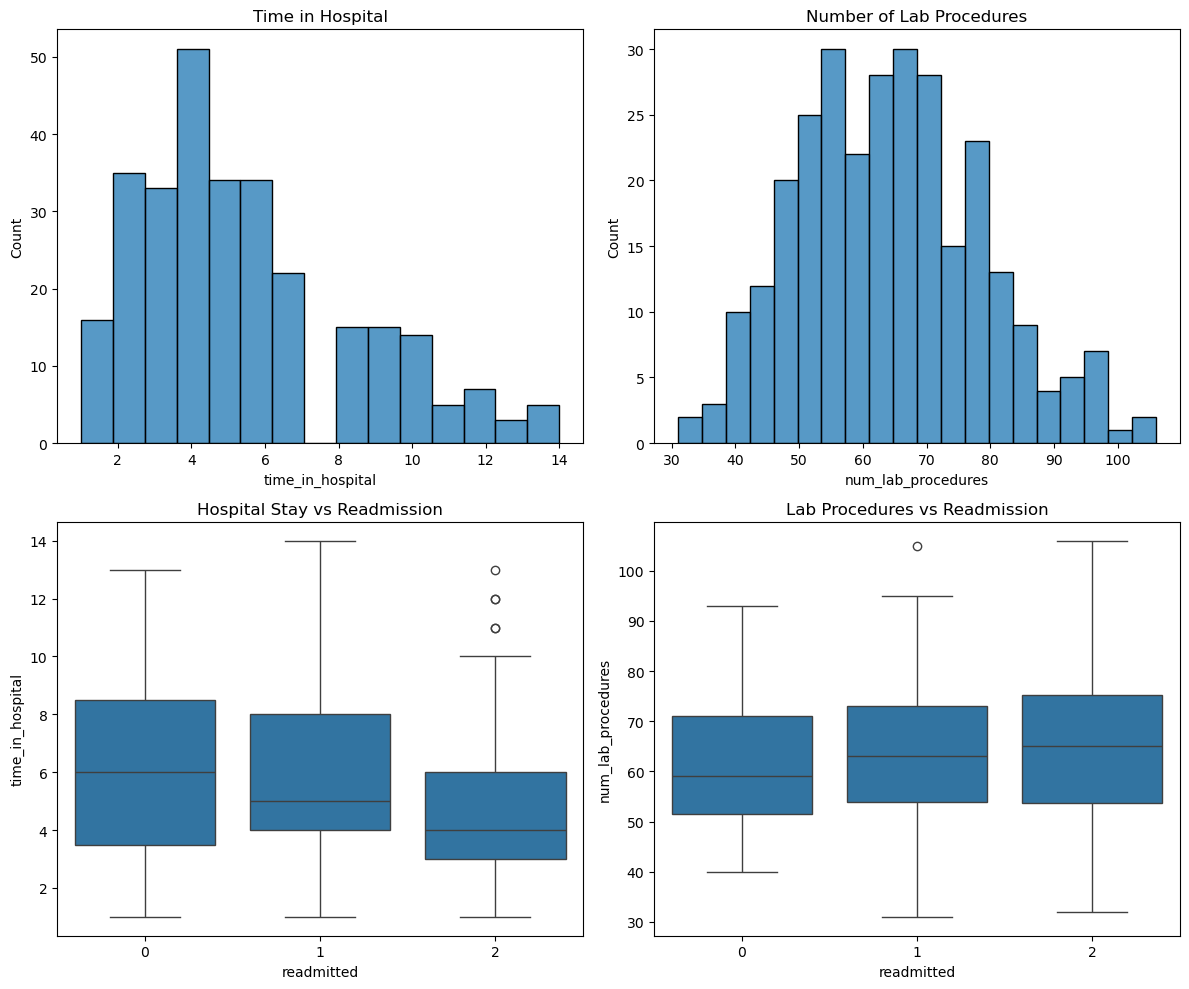

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(df['time_in_hospital'], bins=15, ax=axes[0,0]).set(title='Time in Hospital')
sns.histplot(df['num_lab_procedures'], bins=20, ax=axes[0,1]).set(title='Number of Lab Procedures')
sns.boxplot(x='readmitted', y='time_in_hospital', data=df, ax=axes[1,0]).set(title='Hospital Stay vs Readmission')
sns.boxplot(x='readmitted', y='num_lab_procedures', data=df, ax=axes[1,1]).set(title='Lab Procedures vs Readmission')
plt.tight_layout()
plt.show()

#### Correlation Heatmap

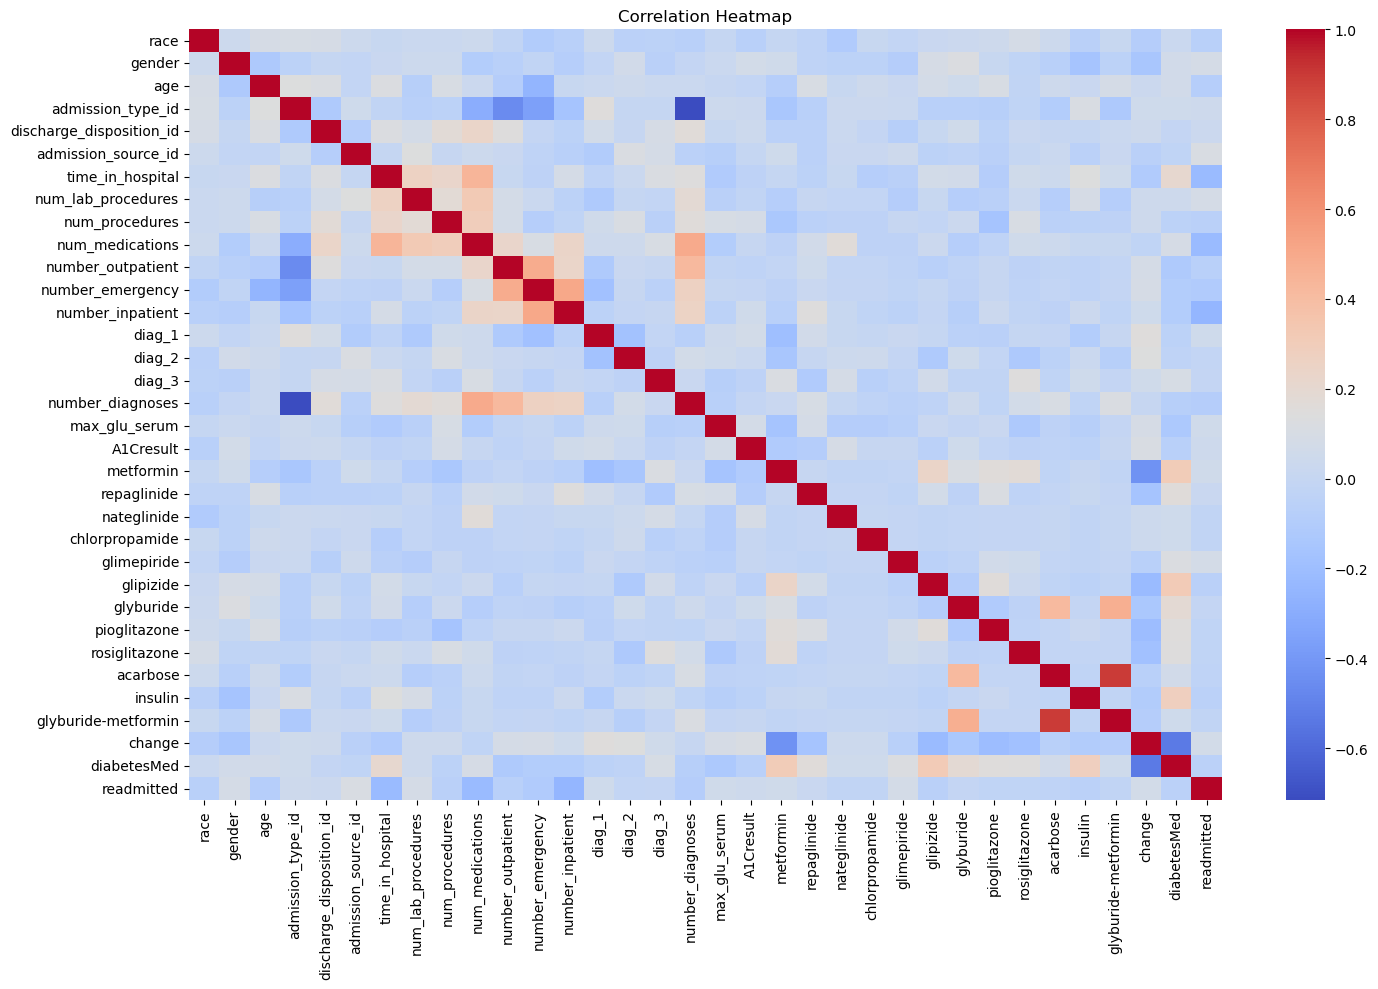

In [12]:

# One-hot encode and keep target
df_encoded = pd.get_dummies(df.drop('readmitted', axis=1))

# Remove columns with all NaNs
df_encoded = df_encoded.dropna(axis=1, how='all')

# Remove columns with constant values (no variance)
df_encoded = df_encoded.loc[:, df_encoded.nunique() > 1]

# Add target back
df_encoded['readmitted'] = df['readmitted']

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df_encoded.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()



#### Encode and Split Data

In [14]:
print ('Start Encoding and Splitting Data')
# Binary classification for readmitted: 1 if <30 days, else 0
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == 0 else 0)  # assuming '<30' encoded as 0

# Feature/target split
X = df.drop('readmitted', axis=1)
y = df['readmitted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print ('Completed Encoding and Splitting Data')


Start Encoding and Splitting Data
Completed Encoding and Splitting Data


#### Model Training with Cross-Validation

In [16]:

# Define Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

# Evaluate each model with cross-validation
for name, model in models.items():
    print(f"\n Evaluating: {name}")
    
    # Get cross-validated predictions
    y_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    # Evaluation metrics
    print("Classification Report:")
    print(classification_report(y, y_pred))
    print(f"Mean ROC-AUC Score: {roc_auc_score(y, y_proba):.4f}")


 Evaluating: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       254
           1       0.00      0.00      0.00        35

    accuracy                           0.87       289
   macro avg       0.44      0.49      0.46       289
weighted avg       0.77      0.87      0.82       289

Mean ROC-AUC Score: 0.5524

 Evaluating: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       254
           1       0.00      0.00      0.00        35

    accuracy                           0.88       289
   macro avg       0.44      0.50      0.47       289
weighted avg       0.77      0.88      0.82       289

Mean ROC-AUC Score: 0.5623

 Evaluating: XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       254
           1       0.18      0

#### Model Evaluation


Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Training SVM...
Training KNN...


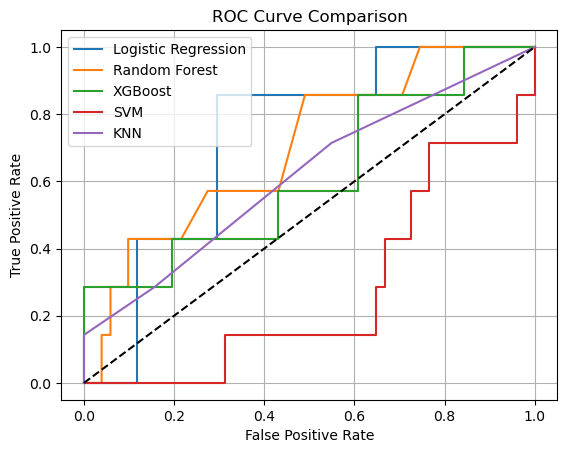

In [17]:

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)  
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()










#### Hyperparameter Tuning (Random Forest)

In [20]:
print ('Starting Hyperparamet tuning')
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
gs = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='roc_auc')
gs.fit(X_train, y_train)
best_model = gs.best_estimator_
print("Best Parameters:", gs.best_params_)

Starting Hyperparamet tuning
Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}


#### Best Model

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        51
           1       0.00      0.00      0.00         7

    accuracy                           0.88        58
   macro avg       0.44      0.50      0.47        58
weighted avg       0.77      0.88      0.82        58

ROC AUC: 0.7591036414565826


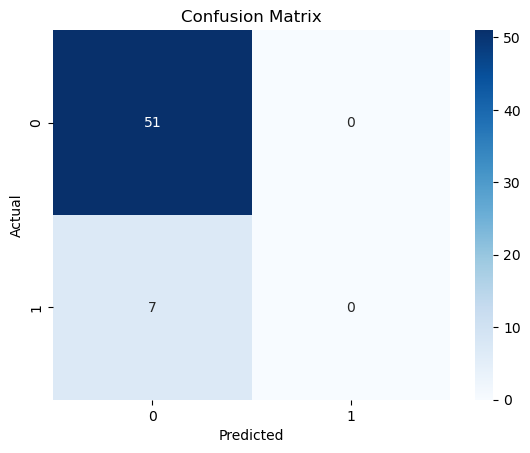

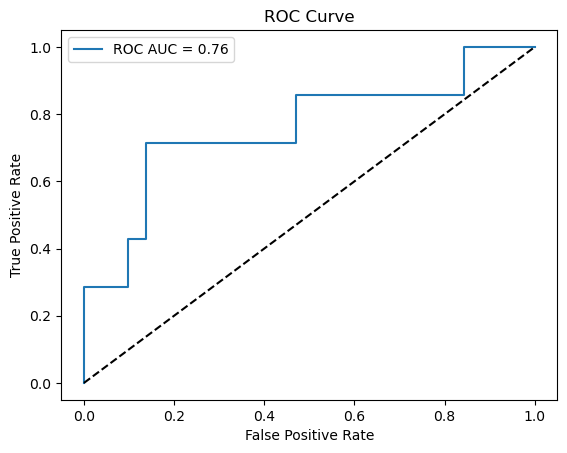

In [22]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [24]:

# Save best model (e.g., Random Forest) with feature names
best_model = models['Random Forest']
joblib.dump((best_model, X.columns.tolist()), 'DIRAPR.pkl')
print("Saved DIRAPR.pkl with model and feature list.")


Saved DIRAPR.pkl with model and feature list.


#### DIRAPR.pkl would be used for hosting  the Streamlit App (DIRAPR.py)
##### Naming Convention
    -All project files follow the naming prefix DIRAPR, an acronym for Diabetic Readmission Prediction, which reflects the central objective of this machine learning project.